In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
engram_dir = '/mnt/smb/locker/issa-locker/users/Erica/'
checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

# A1

ScalarEvent(wall_time=1655271715.6749802, step=38849, value=354.26446533203125)
ScalarEvent(wall_time=1655271768.902931, step=49, value=223.36170959472656)
ScalarEvent(wall_time=1655271768.9038057, step=49, value=401.6320495605469)


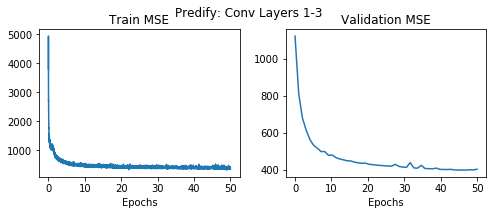

In [56]:
tfdir = tensorboard_dir + 'a1/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-1]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder1')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: Conv Layers 1-3')
plt.tight_layout()
plt.show()

# All

ScalarEvent(wall_time=1655326884.6236863, step=22802, value=403.88641357421875)
ScalarEvent(wall_time=1655326601.3733258, step=28, value=19.513259887695312)
ScalarEvent(wall_time=1655326601.3738213, step=28, value=424.1795654296875)


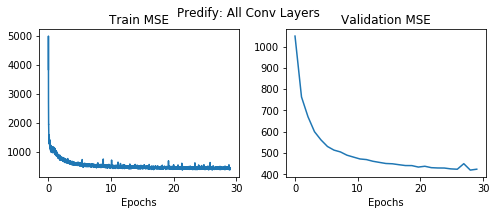

In [62]:
tfdir = tensorboard_dir + 'all/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-1]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder3')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

ScalarEvent(wall_time=1655861912.0847144, step=23952, value=384.37371826171875)
ScalarEvent(wall_time=1655861542.028304, step=29, value=345.4829406738281)
ScalarEvent(wall_time=1655861542.0289855, step=29, value=537.3671875)


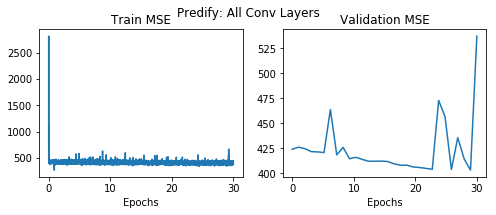

In [58]:
tfdir = tensorboard_dir + 'allpart2/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-1]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder1')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

# Conv1

ScalarEvent(wall_time=1655252336.6149492, step=38849, value=218.5254364013672)
ScalarEvent(wall_time=1655252370.0041301, step=49, value=206.36605834960938)
ScalarEvent(wall_time=1655252370.0047061, step=49, value=206.36605834960938)


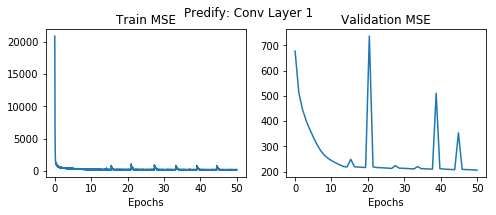

In [59]:
tfdir = tensorboard_dir + 'conv1/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[0]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()
print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder1')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: Conv Layer 1')
plt.tight_layout()
plt.show()

# Conv3

More than one TF file; check it is correct.
ScalarEvent(wall_time=1657257591.5535843, step=17334, value=16894.994140625)
ScalarEvent(wall_time=1657251874.4902723, step=5, value=17480.6171875)
ScalarEvent(wall_time=1657251874.4914227, step=5, value=17480.6171875)


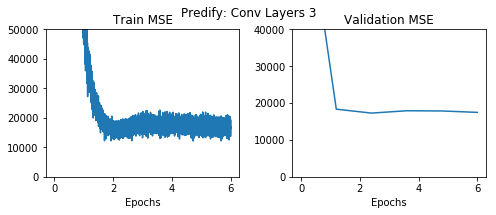

In [60]:
tfdir = tensorboard_dir + 'conv3/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-1]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder1')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylim(0, 0.5*1E5)

axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylim(0, 40000)
plt.suptitle('Predify: Conv Layers 3')
plt.tight_layout()
plt.show()

# Conv345

More than one TF file; check it is correct.
ScalarEvent(wall_time=1657257591.9157352, step=16446, value=2339.370849609375)
ScalarEvent(wall_time=1657253896.9636798, step=5, value=2226.4560546875)
ScalarEvent(wall_time=1657253896.9641557, step=5, value=2276.971923828125)


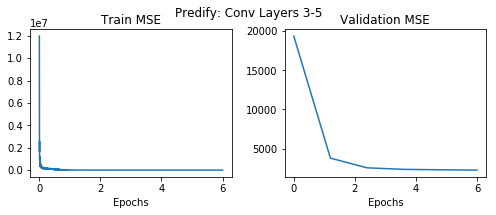

In [61]:
tfdir = tensorboard_dir + 'conv345/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-1]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder1')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')

axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: Conv Layers 3-5')
plt.tight_layout()
plt.show()